In [1]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf
from konlpy.tag import Mecab
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


# 모델구성
from keras.models import Sequential

# 1D CNN
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding

# LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Bidireictional, Attention
from tensorflow.keras.layers import Bidirectional, Attention

# GRU
from tensorflow.keras.layers import GRU


import matplotlib.pyplot as plt
import platform
from tqdm.notebook import tqdm

### Step1. 데이터 불러오기

In [2]:
train_data_path ="~/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


In [3]:
train_data.dtypes

idx              int64
class           object
conversation    object
dtype: object

In [4]:
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
    # 이와 같이 레이블과 숫자를 매핑해줍니다.
}
train_data['class'] = train_data['class'].replace(label_mapping).astype('int')

In [5]:
train_data

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [6]:
train_data.dtypes

idx              int64
class            int64
conversation    object
dtype: object

In [7]:
test_data_path ="~/data/test.json"
test_data = pd.read_json(test_data_path)
test_data = test_data.transpose()
test_data.to_csv("test_data.csv", mode="w")

In [8]:
test_data = pd.read_csv('./test_data.csv', index_col= 0)
test_data.tail()

,text
t_495,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...
t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...
t_497,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...
t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...
t_499,엄마 저 그 돈 안해주시면 정말 큰일나요. 이유도 말하지 않고. 몇번째니 경민아....


In [9]:
len(test_data)

400

In [10]:
# 협박 00
# 갈취 01
# 직장 내 괴롭힘 02
# 기타 괴롭힘 03

In [11]:
# test_data['class'] = 0.0*100, 0.1, 0.2, 0.3
# test_data.insert(1, 'class', [0.0, 0.1, 0.2, 0.3])

In [10]:
test_data['class'] = 0.0
test_data['class'] = test_data['class'].astype('float')
test_data.dtypes

text      object
class    float64
dtype: object

In [11]:
test_data.iloc[396]

text     교수님 제 논문에 제 이름이 없나요?  아 무슨 논문말이야?  지난 번 냈던 논문이...
class                                                  0.0
Name: t_496, dtype: object

In [14]:
# sample_answersheet_path ="~/data/sample_answersheet.json"
# sample_answersheet_data = pd.read_json(sample_answersheet_path)
# sample_answersheet_data.tail()
# # sample_answersheet_data = sample_answersheet_data.transpose()
# # sample_answersheet_data.to_csv("sample_answersheet_.csv", mode="w")

1. 데이터 살펴보기

In [12]:
train_data.groupby('class').count()

,idx,conversation
class,,
0,896,896
1,981,981
2,979,979
3,1094,1094


2. 데이터 중복 제거 

In [13]:
train_data2 = train_data.drop_duplicates(['conversation'])  # conversation만 같아도 지워진 꼴이 됐음;
train_data2

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,3,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,1,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,2,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,1,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


3. 데이터 분포 보기

Data Size: 3846
문장의 최단 길이: 41
문장의 최장 길이: 874
문장의 평균 길이: 227


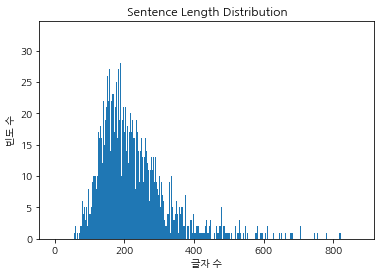

In [14]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus_cov = list(set(train_data.conversation))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus_cov))



# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')  # 리눅스의 경우 나눔고딕 폰트를 사용하도록 변경해주세요.

# 그래프에서 마이너스 기호가 표시되도록 설정
plt.rc('axes', unicode_minus=False)



for sen in cleaned_corpus_cov:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus_cov))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus_cov:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.xlabel(xlabel='글자 수')
plt.ylabel(ylabel='빈도 수')
plt.show()

최대길이: 874
최소길이: 41
평균길이: 226.57088607594937


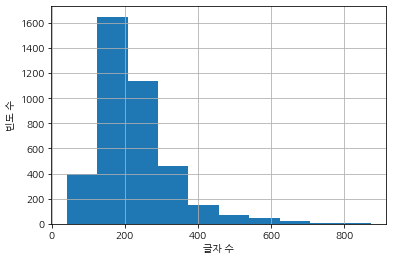

In [15]:
# 중복제거 
ax = train_data.conversation.str.len().hist()

max_length = train_data.conversation.str.len().max()
min_length = train_data.conversation.str.len().min()
mean_length = train_data.conversation.str.len().mean()

ax.set_xlabel(xlabel='글자 수')
ax.set_ylabel(ylabel='빈도 수')

print("최대길이:", max_length)
print("최소길이:", min_length)
print("평균길이:", mean_length)

중복을 제거하나 안하나 별 차이가 없다. 그냥 데이터 정제나 해야겠다. 

In [16]:
cleaned_corpus_cov[0]

'뭐해 ?\n 나 지금 새로 생긴 일 때문에 잠시 나왔지.\n 뭐? 너 그런 이야기 없었잖아?\n 응 근데 갑자기 잡혔어. 근데 너 내가 거의 실시간으로 일정 보고도 하고 새로운 스케줄 생기는대로 바로 알려주는데도 왜그렇게 화를 내\n 좋아하면 이해해줘야되는 거 아냐? 난 불안해. 니가 날 사랑하는지 확신이 필요하다고 했잖아.\n 확신이 부족해? 나 솔직히 힘들어\n 뭐? 너 나를 사랑하긴 해? 왜 못알려주는데? 난 미칠거같은데\n 아니 아니 알려 줄 수는 있는데.\n 있는데 뭐? 거기에 왜 다른 말이 붙어? 너 나한테 이러면 안돼는 거잖아.\n 후. 미안. 내가 잘못했어'

In [17]:
type(cleaned_corpus_cov)

list

### Step2. 데이터 정제

In [18]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


x_train, x_test, y_train, y_test = train_test_split(train_data2['conversation'], train_data2['class'], test_size=0.2)

In [19]:
x_val = test_data['text']
y_val = test_data['class']

In [20]:
token_data = tokenizer.morphs(cleaned_corpus_cov[0])
token_data

['뭐',
 '해',
 '?',
 '나',
 '지금',
 '새로',
 '생긴',
 '일',
 '때문',
 '에',
 '잠시',
 '나왔',
 '지',
 '.',
 '뭐',
 '?',
 '너',
 '그런',
 '이야기',
 '없',
 '었',
 '잖아',
 '?',
 '응',
 '근데',
 '갑자기',
 '잡혔',
 '어',
 '.',
 '근데',
 '너',
 '내',
 '가',
 '거의',
 '실시간',
 '으로',
 '일정',
 '보고',
 '도',
 '하',
 '고',
 '새로운',
 '스케줄',
 '생기',
 '는',
 '대로',
 '바로',
 '알려',
 '주',
 '는데',
 '도',
 '왜',
 '그렇게',
 '화',
 '를',
 '내',
 '좋',
 '아',
 '하',
 '면',
 '이해',
 '해',
 '줘야',
 '되',
 '는',
 '거',
 '아냐',
 '?',
 '난',
 '불안',
 '해',
 '.',
 '니',
 '가',
 '날',
 '사랑',
 '하',
 '는지',
 '확신',
 '이',
 '필요',
 '하',
 '다고',
 '했잖아',
 '.',
 '확신',
 '이',
 '부족',
 '해',
 '?',
 '나',
 '솔직히',
 '힘들',
 '어',
 '뭐',
 '?',
 '너',
 '나',
 '를',
 '사랑',
 '하',
 '긴',
 '해',
 '?',
 '왜',
 '못',
 '알려',
 '주',
 '는데',
 '?',
 '난',
 '미칠',
 '거',
 '같',
 '은데',
 '아니',
 '아니',
 '알려',
 '줄',
 '수',
 '는',
 '있',
 '는데',
 '.',
 '있',
 '는데',
 '뭐',
 '?',
 '거기',
 '에',
 '왜',
 '다른',
 '말',
 '이',
 '붙',
 '어',
 '?',
 '너',
 '나',
 '한테',
 '이러',
 '면',
 '안',
 '돼',
 '는',
 '거',
 '잖',
 '아',
 '.',
 '후',
 '.',
 '미안',
 '.',
 '내',
 '가',
 '잘못',


In [21]:
# type(x_train)
# x_train[0]
x_val[0]
y_val[0]

0.0

In [22]:
X_train= []
for sentence in x_train:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
    
X_test= []
for sentence in x_test:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

X_val = []
for sentence in x_val:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_val.append(temp_X)
    
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)
print("counter:",   len(counter))
vocab = ['<PAD>','<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
print("word_to_index:", len(word_to_index))

def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]


X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))
y_train = np.array(y_train)
y_test = np.array(y_test)

X_val = list(map(wordlist_to_indexlist, X_val))
y_val = np.array(y_val)

counter: 9996
word_to_index: 10000


In [23]:
print(len(X_train), len(y_train)) 
print(len(X_test), len(y_test)) 
print(len(X_val), len(y_val))

3076 3076
770 770
400 400


In [24]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

num_tokens길이: 3846
토큰길이 최소: 21
토큰길이 최대: 394
토큰길이 평균: 103.80213208528342
토큰길이 표준편차: 46.752633532284385


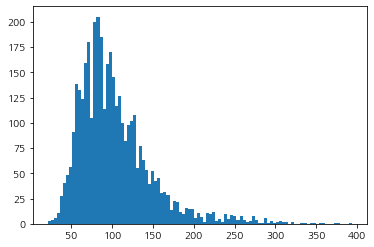

In [25]:
# 데이터셋 내 문장 길이 분포 확인
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print("num_tokens길이:", len(num_tokens))  # 195399
# print(num_tokens)



# 문장길이의 최소값, 최대값, 평균값, 표준편차
print('토큰길이 최소:', np.min(num_tokens))
print('토큰길이 최대:', np.max(num_tokens))
print('토큰길이 평균:', np.mean(num_tokens))
print('토큰길이 표준편차:', np.std(num_tokens))


plt.hist(num_tokens, bins=100)
plt.show()

In [29]:
# 최대 길이를 (평균 + 2*표준편차)로 한다면
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen :', maxlen)
ratio = np.sum(num_tokens<max_tokens)/len(num_tokens)
print(f'전체 문장의 {round(ratio, 4)}%가 설정 가능한 범위내의 비율')

pad_sequences maxlen : 197
전체 문장의 0.9529%가 설정 가능한 범위내의 비율


In [30]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, 
                                                        value = word_to_index['<PAD>'],
                                                        padding='pre',  # 혹은 post
                                                        maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=400)


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3076, 197)
(770, 197)
(400, 400)


In [31]:
vocab_size = len(word_to_index)
num_words = 10000

vocab_size

10000

### Step 3: 모델설계

In [34]:
word_vector_dim_cnn = 32


model1 = tf.keras.Sequential()
model1.add(Embedding(vocab_size, word_vector_dim_cnn, input_length = maxlen))
model1.add(Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(Conv1D(16, 7, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()
# tf.keras.utils.plot_model(model1, show_shapes=True)
model1.save('model1.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 197, 32)           320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 191, 16)           3600      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 32, 16)            1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [35]:
# (2) LSTM
word_vector_dim_lstm = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_lstm, input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
model2.add(tf.keras.layers.LSTM(16))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
# tf.keras.utils.plot_model(model2, show_shapes=True)

model2.summary()
model2.save('model2.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 197, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 323,281
Trainable params: 323,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# (3) GRU

word_vector_dim_GRU = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GRU 레이어로 모델 설계
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_GRU, input_length = maxlen))
model3.add(tf.keras.layers.GRU(16))  # GRU state 벡터의 차원수 (변경가능)
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(8, activation='sigmoid'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model3.summary()

In [ ]:
# (4) BiLSTM
word_vector_dim_Bi = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim_Bi, input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.Bidirectional(LSTM(16)))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(8, activation='sigmoid')) 
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

### Step 4: 훈련하기

모델 바꿔가면서 실험 가능 
1) 1D CNN <br>
2) LSTM <br>
3) GRU <br>
4) BiLSTM <br>

In [ ]:
# model1_CNN (loss: -6.3858 - accuracy: 0.2542 - val_loss: -7.1614 - val_accuracy: 0.2481)

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history1 = model1.fit(X_train, 
                     y_train,
                     epochs=epochs,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     verbose=1)

In [ ]:
# model1_CNN (loss: -6.3858 - accuracy: 0.2542 - val_loss: -7.1614 - val_accuracy: 0.2481)

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history11 = model1.fit(X_train, 
                     y_train,
                     epochs=epochs,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     verbose=1)

In [ ]:
test_data_1dcnn = test_data.drop(['text'], axis=1)
test_data_1dcnn.to_csv('test_data_1dcnn.csv')

In [ ]:
test_data_1dcnn

In [ ]:
pd.read_csv('test_data_1dcnn.csv', index_col=0)

In [ ]:
# model2_LSTM (loss: -3.5427 - accuracy: 0.2542 - val_loss: -4.0413 - val_accuracy: 0.2481)

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history2 = model2.fit(X_train, 
                     y_train,
                     epochs=epochs,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     verbose=1)


In [ ]:
# model3_GRU (loss: 0.1279 - accuracy: 0.2575 - val_loss: -0.6897 - val_accuracy: 0.2481)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history3 = model3.fit(X_train, 
                     y_train,
                     epochs=epochs,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     verbose=1)

In [ ]:
# model4 _Bidirectional (loss: -9.2861 - accuracy: 0.2542 - val_loss: -10.3372 - val_accuracy: 0.2481)
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # overfitting 방지를 위해 epoch낮춤 

history4 = model4.fit(X_train, 
                     y_train,
                     epochs=epochs,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     verbose=1)